# Notebook 2: Entrenamiento de Modelos de Clasificación (GPU)

**Proyecto:** Entrega Final - Optimización de Estrategias de Retención

**Autores:** Juan David Valencia, Juan Esteban Cuellar

**Fecha:** Noviembre 2025

---

## 🚀 Versión optimizada para Google Colab con GPU

**Para usar GPU en Colab:**
1. Ir a Runtime → Change runtime type
2. Seleccionar GPU (T4 recomendado)
3. Ejecutar todas las celdas

---

## Objetivo

Este notebook implementa el **entrenamiento, optimización y evaluación de modelos de clasificación** para predecir usuarios con alto potencial de crecimiento (`high_growth`).

**Problema de Negocio:** Identificar qué usuarios tienen mayor probabilidad de convertirse en usuarios de alto crecimiento (delta_orders > 8) para optimizar asignación de presupuesto promocional.

**Variable Objetivo:** `high_growth` (binaria: 1 si delta_orders > 8, 0 si no)

**Algoritmos a Comparar:**
1. Random Forest Classifier (CPU - no tiene soporte GPU en sklearn)
2. XGBoost Classifier (GPU - acelerado con CUDA)
3. LightGBM Classifier (GPU - acelerado con CUDA)

**Métricas de Evaluación:**
- **AUC-ROC** (objetivo: > 0.75) - Métrica principal
- **F1-Score** (objetivo: > 0.65)
- **Precision@20%** (objetivo: > 0.80) - Para targeting top-20% usuarios
- Matriz de confusión
- Curvas ROC y Precision-Recall

**Entrada:** Datasets procesados de `data/processed/`

**Salida:** 
- Mejor modelo entrenado: `models/best_classifier.pkl`
- Reporte de evaluación: `models/classification_report.json`
- Visualizaciones: `documento/figuras/model_*.png`

---

## 1. Estrategia de Validación y Experimentación (Fase 3 - 5%)

### 1.1 Estrategia de Experimentación

**Proceso de Modelado:**

1. **Entrenamiento Inicial:**
   - Entrenar múltiples algoritmos (RF, XGBoost, LightGBM) en conjunto **TRAIN**
   - Usar configuraciones baseline para establecer línea base de desempeño

2. **Optimización de Hiperparámetros:**
   - Usar **5-fold Cross-Validation** en conjunto TRAIN para optimizar hiperparámetros
   - Técnica: **GridSearchCV** (exploración exhaustiva del espacio de parámetros)
   - Métrica de optimización: **AUC-ROC** (balance entre sensibilidad y especificidad)

3. **Selección de Modelo:**
   - Evaluar mejor configuración de cada algoritmo en conjunto **VALIDATION**
   - Comparar modelos usando métricas múltiples (AUC-ROC, F1, Precision@20%)
   - Seleccionar mejor modelo basado en criterios de negocio + métricas estadísticas

4. **Evaluación Final:**
   - Evaluar mejor modelo en conjunto **TEST** (1 sola vez, sin reentrenamiento)
   - Reportar métricas finales + intervalos de confianza
   - Análisis cualitativo: feature importance, casos mal clasificados

### 1.2 Justificación de la Estrategia

- **5-fold CV:** Balance entre robustez (múltiples folds) y costo computacional
- **GridSearchCV:** Garantiza exploración sistemática del espacio de hiperparámetros
- **Hold-out test set:** Evaluación no sesgada del desempeño final (conjunto nunca visto)
- **AUC-ROC como métrica primaria:** Insensible a desbalance de clases (20% high-growth)

### 1.3 Verificación de Distribuciones

Verificaremos que los conjuntos Train/Val/Test preservan las distribuciones de las variables clave.

## 2. Setup y Carga de Datos

### Configuración de GPU para Colab

In [1]:
# ============================================================================
# CONFIGURACIÓN DE GPU PARA GOOGLE COLAB
# ============================================================================

import subprocess
import sys

# Detectar si estamos en Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Ejecutando en Google Colab")
    
    # Verificar GPU disponible
    try:
        gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'])
        gpu_name = gpu_info.decode('utf-8').strip()
        print(f"🎮 GPU detectada: {gpu_name}")
        GPU_AVAILABLE = True
    except:
        print("⚠️ No se detectó GPU. Usando CPU.")
        GPU_AVAILABLE = False
    
    # Instalar dependencias si es necesario
    print("\n📦 Instalando dependencias...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'xgboost', 'lightgbm'])
else:
    print("💻 Ejecutando localmente")
    # Verificar GPU localmente
    try:
        import torch
        GPU_AVAILABLE = torch.cuda.is_available()
        if GPU_AVAILABLE:
            print(f"🎮 GPU disponible: {torch.cuda.get_device_name(0)}")
    except:
        GPU_AVAILABLE = False
        print("⚠️ Ejecutando en CPU")

print(f"\n✅ GPU_AVAILABLE = {GPU_AVAILABLE}")

💻 Ejecutando localmente
⚠️ Ejecutando en CPU

✅ GPU_AVAILABLE = False


In [2]:
# Imports
import pandas as pd
import numpy as np
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn - Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    average_precision_score
)

# XGBoost y LightGBM
import xgboost as xgb
import lightgbm as lgb

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Configuración
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Imports completados")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n📦 Versiones:")
print(f"   - XGBoost: {xgb.__version__}")
print(f"   - LightGBM: {lgb.__version__}")

# Configurar dispositivo para modelos
if GPU_AVAILABLE:
    # XGBoost GPU config
    XGB_DEVICE = 'cuda'
    XGB_TREE_METHOD = 'hist'  # hist es más rápido con GPU
    
    # LightGBM GPU config
    LGB_DEVICE = 'gpu'
    
    print(f"\n🚀 Modelos configurados para GPU:")
    print(f"   - XGBoost: device={XGB_DEVICE}, tree_method={XGB_TREE_METHOD}")
    print(f"   - LightGBM: device={LGB_DEVICE}")
else:
    XGB_DEVICE = 'cpu'
    XGB_TREE_METHOD = 'hist'
    LGB_DEVICE = 'cpu'
    print(f"\n💻 Modelos configurados para CPU")

✅ Imports completados
📅 Fecha de ejecución: 2025-11-29 17:49:37

📦 Versiones:
   - XGBoost: 3.1.2
   - LightGBM: 4.6.0

💻 Modelos configurados para CPU


In [3]:
# Cargar datasets procesados
# Ajustar paths según el entorno

if IN_COLAB:
    # En Colab, montar Google Drive o subir archivos
    from google.colab import drive
    
    # Intentar montar Drive
    try:
        drive.mount('/content/drive')
        BASE_PATH = '/content/drive/MyDrive/Proyecto_DS'  # Ajustar según tu estructura
        print("📁 Google Drive montado")
    except:
        # Si no se monta, usar directorio actual
        BASE_PATH = '.'
        print("📁 Usando directorio actual - sube los archivos manualmente")
    
    TRAIN_PATH = f'{BASE_PATH}/data/processed/train.csv'
    VAL_PATH = f'{BASE_PATH}/data/processed/val.csv'
    TEST_PATH = f'{BASE_PATH}/data/processed/test.csv'
else:
    # Ejecución local
    TRAIN_PATH = '../data/processed/train.csv'
    VAL_PATH = '../data/processed/val.csv'
    TEST_PATH = '../data/processed/test.csv'

print("📂 Cargando datasets procesados...\n")

train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"✅ Train: {train_df.shape[0]:,} usuarios × {train_df.shape[1]} features")
print(f"✅ Validation: {val_df.shape[0]:,} usuarios × {val_df.shape[1]} features")
print(f"✅ Test: {test_df.shape[0]:,} usuarios × {test_df.shape[1]} features")

print(f"\n📊 Distribución de high_growth:")
print(f"   - Train: {train_df['high_growth'].mean()*100:.2f}% positivos")
print(f"   - Validation: {val_df['high_growth'].mean()*100:.2f}% positivos")
print(f"   - Test: {test_df['high_growth'].mean()*100:.2f}% positivos")

📂 Cargando datasets procesados...

✅ Train: 25,000 usuarios × 54 features
✅ Validation: 8,333 usuarios × 54 features
✅ Test: 8,334 usuarios × 54 features

📊 Distribución de high_growth:
   - Train: 20.36% positivos
   - Validation: 20.35% positivos
   - Test: 20.36% positivos


In [4]:
# Separar features y targets
# Recordar: uid, high_growth, delta_orders no son features

feature_cols = [col for col in train_df.columns if col not in ['uid', 'high_growth', 'delta_orders']]

X_train = train_df[feature_cols]
y_train = train_df['high_growth']

X_val = val_df[feature_cols]
y_val = val_df['high_growth']

X_test = test_df[feature_cols]
y_test = test_df['high_growth']

print(f"📊 Features para modelado: {len(feature_cols)}")
print(f"\n📋 Primeras 10 features:")
for i, feat in enumerate(feature_cols[:10], 1):
    print(f"   {i:2d}. {feat}")
print(f"   ... ({len(feature_cols) - 10} features más)")

print(f"\n✅ X_train: {X_train.shape}")
print(f"✅ y_train: {y_train.shape} (positivos: {y_train.sum():,} = {y_train.mean()*100:.2f}%)")

📊 Features para modelado: 51

📋 Primeras 10 features:
    1. total_orders_tmenos1
    2. efo_to_four
    3. log_efo_to_four
    4. category_diversity
    5. num_categories
    6. num_shops
    7. num_brands
    8. brand001_ratio
    9. days_since_first_order
   10. orders_per_day
   ... (41 features más)

✅ X_train: (25000, 51)
✅ y_train: (25000,) (positivos: 5,090 = 20.36%)


### 2.1 Verificación de Distribuciones

Verificamos que las distribuciones se preservan entre Train/Val/Test.

In [5]:
from scipy.stats import chi2_contingency

print("🔍 Verificando preservación de distribuciones...\n")

# Verificar high_growth
contingency_table = pd.DataFrame({
    'Train': y_train.value_counts(sort=False),
    'Validation': y_val.value_counts(sort=False),
    'Test': y_test.value_counts(sort=False)
})

print("📊 Tabla de Contingencia (high_growth):")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table.values)

print(f"\n📈 Test Chi-Cuadrado:")
print(f"   - Chi² = {chi2:.4f}")
print(f"   - P-valor = {p_value:.4f}")
print(f"   - Conclusión: {'✅ Distribuciones preservadas (p > 0.05)' if p_value > 0.05 else '⚠️ Posible diferencia en distribuciones'}")

# Verificar distribución de delta_orders (target de regresión)
print(f"\n📊 Estadísticas de delta_orders:")
stats_df = pd.DataFrame({
    'Train': train_df['delta_orders'].describe(),
    'Validation': val_df['delta_orders'].describe(),
    'Test': test_df['delta_orders'].describe()
})
print(stats_df)

print(f"\n✅ Verificación completada: Distribuciones adecuadas para modelado")

🔍 Verificando preservación de distribuciones...

📊 Tabla de Contingencia (high_growth):
             Train  Validation  Test
high_growth                         
0            19910        6637  6637
1             5090        1696  1697

📈 Test Chi-Cuadrado:
   - Chi² = 0.0003
   - P-valor = 0.9999
   - Conclusión: ✅ Distribuciones preservadas (p > 0.05)

📊 Estadísticas de delta_orders:
              Train   Validation         Test
count  25000.000000  8333.000000  8334.000000
mean       6.846280     6.840034     6.888649
std        4.870811     5.105109     5.063934
min        1.000000     1.000000     1.000000
25%        4.000000     4.000000     4.000000
50%        5.000000     5.000000     5.000000
75%        8.000000     8.000000     8.000000
max       95.000000   108.000000    65.000000

✅ Verificación completada: Distribuciones adecuadas para modelado


## 3. Modelo Baseline: Random Forest Classifier

Comenzamos con Random Forest como modelo baseline por su robustez y facilidad de interpretación.

In [6]:
print("🌲 RANDOM FOREST CLASSIFIER - Configuración Baseline\n")

# Configuración baseline
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Manejar desbalance de clases
)

print("⏳ Entrenando Random Forest baseline...")
rf_baseline.fit(X_train, y_train)

# Predicciones
y_train_pred_rf = rf_baseline.predict(X_train)
y_train_proba_rf = rf_baseline.predict_proba(X_train)[:, 1]

y_val_pred_rf = rf_baseline.predict(X_val)
y_val_proba_rf = rf_baseline.predict_proba(X_val)[:, 1]

# Métricas
print(f"\n📊 Métricas Random Forest (Baseline):")
print(f"\n{'='*60}")
print(f"{'Métrica':<25} {'Train':>15} {'Validation':>15}")
print(f"{'='*60}")
print(f"{'AUC-ROC':<25} {roc_auc_score(y_train, y_train_proba_rf):>15.4f} {roc_auc_score(y_val, y_val_proba_rf):>15.4f}")
print(f"{'F1-Score':<25} {f1_score(y_train, y_train_pred_rf):>15.4f} {f1_score(y_val, y_val_pred_rf):>15.4f}")
print(f"{'Precision':<25} {precision_score(y_train, y_train_pred_rf):>15.4f} {precision_score(y_val, y_val_pred_rf):>15.4f}")
print(f"{'Recall':<25} {recall_score(y_train, y_train_pred_rf):>15.4f} {recall_score(y_val, y_val_pred_rf):>15.4f}")
print(f"{'Accuracy':<25} {accuracy_score(y_train, y_train_pred_rf):>15.4f} {accuracy_score(y_val, y_val_pred_rf):>15.4f}")
print(f"{'='*60}")

print(f"\n✅ Random Forest baseline entrenado")

🌲 RANDOM FOREST CLASSIFIER - Configuración Baseline

⏳ Entrenando Random Forest baseline...

📊 Métricas Random Forest (Baseline):

Métrica                             Train      Validation
AUC-ROC                            0.9935          0.9906
F1-Score                           0.8812          0.8752
Precision                          0.8105          0.8031
Recall                             0.9654          0.9617
Accuracy                           0.9470          0.9442

✅ Random Forest baseline entrenado


### 3.1 Optimización de Hiperparámetros - Random Forest

In [7]:
print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - Random Forest\n")

# Grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

print(f"📋 Grid de búsqueda:")
for param, values in param_grid_rf.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"\n🔢 Total de combinaciones: {total_combinations:,}")
print(f"⏱️ Tiempo estimado: ~{total_combinations * 5 // 60} minutos (con 5-fold CV)\n")

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("⏳ Iniciando GridSearchCV para Random Forest...")
print("   (Esto puede tomar varios minutos)\n")

rf_grid.fit(X_train, y_train)

print(f"\n✅ Optimización completada!")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in rf_grid.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Mejor AUC-ROC (5-fold CV): {rf_grid.best_score_:.4f}")

# Guardar mejor modelo
best_rf = rf_grid.best_estimator_

🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - Random Forest

📋 Grid de búsqueda:
   - n_estimators: [100, 200, 300]
   - max_depth: [10, 15, 20, None]
   - min_samples_split: [10, 20, 30]
   - min_samples_leaf: [5, 10, 15]
   - max_features: ['sqrt', 'log2']

🔢 Total de combinaciones: 216
⏱️ Tiempo estimado: ~18 minutos (con 5-fold CV)

⏳ Iniciando GridSearchCV para Random Forest...
   (Esto puede tomar varios minutos)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Optimización completada!

🏆 Mejores hiperparámetros:
   - max_depth: None
   - max_features: sqrt
   - min_samples_leaf: 5
   - min_samples_split: 10
   - n_estimators: 300

📊 Mejor AUC-ROC (5-fold CV): 0.9942


In [8]:
# Evaluar mejor Random Forest en validation
y_val_pred_rf_opt = best_rf.predict(X_val)
y_val_proba_rf_opt = best_rf.predict_proba(X_val)[:, 1]

print(f"📊 Métricas Random Forest (Optimizado) en Validation:")
print(f"   - AUC-ROC: {roc_auc_score(y_val, y_val_proba_rf_opt):.4f}")
print(f"   - F1-Score: {f1_score(y_val, y_val_pred_rf_opt):.4f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_rf_opt):.4f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_rf_opt):.4f}")

# Precision@20%
top_20_idx = np.argsort(y_val_proba_rf_opt)[-int(len(y_val) * 0.20):]
precision_at_20 = y_val.iloc[top_20_idx].mean()
print(f"   - Precision@20%: {precision_at_20:.4f}")

📊 Métricas Random Forest (Optimizado) en Validation:
   - AUC-ROC: 0.9953
   - F1-Score: 0.9179
   - Precision: 0.8774
   - Recall: 0.9623
   - Precision@20%: 0.9334


## 4. Modelo 2: XGBoost Classifier

In [9]:
print("🚀 XGBOOST CLASSIFIER - Configuración Baseline (GPU)\n")

# Calcular scale_pos_weight para manejar desbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Scale pos weight: {scale_pos_weight:.2f}")
print(f"🎮 Dispositivo: {XGB_DEVICE}")

# Baseline con GPU
xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    # GPU Configuration
    device=XGB_DEVICE,
    tree_method=XGB_TREE_METHOD
)

print("⏳ Entrenando XGBoost baseline...")
xgb_baseline.fit(X_train, y_train)

y_val_pred_xgb = xgb_baseline.predict(X_val)
y_val_proba_xgb = xgb_baseline.predict_proba(X_val)[:, 1]

print(f"\n📊 Métricas XGBoost (Baseline) en Validation:")
print(f"   - AUC-ROC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")
print(f"   - F1-Score: {f1_score(y_val, y_val_pred_xgb):.4f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_xgb):.4f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_xgb):.4f}")

print(f"\n✅ XGBoost baseline entrenado")

🚀 XGBOOST CLASSIFIER - Configuración Baseline (GPU)

⚖️ Scale pos weight: 3.91
🎮 Dispositivo: cpu
⏳ Entrenando XGBoost baseline...

📊 Métricas XGBoost (Baseline) en Validation:
   - AUC-ROC: 0.9999
   - F1-Score: 0.9965
   - Precision: 0.9965
   - Recall: 0.9965

✅ XGBoost baseline entrenado


### 4.1 Optimización de Hiperparámetros - XGBoost

In [ ]:
print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost (GPU)\n")
print(f"🎮 Dispositivo: {XGB_DEVICE}")

# Grid reducido para GPU (más rápido)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print(f"📋 Grid de búsqueda:")
for param, values in param_grid_xgb.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_xgb.values()])
print(f"\n🔢 Total de combinaciones: {total_combinations:,}")
print(f"⏱️ Tiempo estimado con GPU: ~{total_combinations // 60} minutos\n")

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
        # GPU Configuration
        device=XGB_DEVICE,
        tree_method=XGB_TREE_METHOD
    ),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=1 if GPU_AVAILABLE else -1,  # Con GPU usar 1 job
    verbose=1
)

print("⏳ Iniciando GridSearchCV para XGBoost...")
xgb_grid.fit(X_train, y_train)

print(f"\n✅ Optimización completada!")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in xgb_grid.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Mejor AUC-ROC (5-fold CV): {xgb_grid.best_score_:.4f}")

best_xgb = xgb_grid.best_estimator_

🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost (GPU)

🎮 Dispositivo: cpu
📋 Grid de búsqueda:
   - n_estimators: [100]
   - max_depth: [4, 10]
   - learning_rate: [0.1]
   - subsample: [0.9]
   - colsample_bytree: [0.7]

🔢 Total de combinaciones: 2
⏱️ Tiempo estimado con GPU: ~0 minutos

⏳ Iniciando GridSearchCV para XGBoost...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

✅ Optimización completada!

🏆 Mejores hiperparámetros:
   - colsample_bytree: 0.7
   - learning_rate: 0.1
   - max_depth: 10
   - n_estimators: 100
   - subsample: 0.9

📊 Mejor AUC-ROC (5-fold CV): 1.0000


In [11]:
# Evaluar mejor XGBoost en validation
y_val_pred_xgb_opt = best_xgb.predict(X_val)
y_val_proba_xgb_opt = best_xgb.predict_proba(X_val)[:, 1]

print(f"📊 Métricas XGBoost (Optimizado) en Validation:")
print(f"   - AUC-ROC: {roc_auc_score(y_val, y_val_proba_xgb_opt):.4f}")
print(f"   - F1-Score: {f1_score(y_val, y_val_pred_xgb_opt):.4f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_xgb_opt):.4f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_xgb_opt):.4f}")

# Precision@20%
top_20_idx_xgb = np.argsort(y_val_proba_xgb_opt)[-int(len(y_val) * 0.20):]
precision_at_20_xgb = y_val.iloc[top_20_idx_xgb].mean()
print(f"   - Precision@20%: {precision_at_20_xgb:.4f}")

📊 Métricas XGBoost (Optimizado) en Validation:
   - AUC-ROC: 0.9999
   - F1-Score: 0.9971
   - Precision: 0.9965
   - Recall: 0.9976
   - Precision@20%: 0.9994


## 5. Modelo 3: LightGBM Classifier

In [12]:
print("⚡ LIGHTGBM CLASSIFIER - Configuración Baseline (GPU)\n")
print(f"🎮 Dispositivo: {LGB_DEVICE}")

# Baseline con GPU
lgb_baseline = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    # GPU Configuration
    device=LGB_DEVICE
)

print("⏳ Entrenando LightGBM baseline...")
lgb_baseline.fit(X_train, y_train)

y_val_pred_lgb = lgb_baseline.predict(X_val)
y_val_proba_lgb = lgb_baseline.predict_proba(X_val)[:, 1]

print(f"\n📊 Métricas LightGBM (Baseline) en Validation:")
print(f"   - AUC-ROC: {roc_auc_score(y_val, y_val_proba_lgb):.4f}")
print(f"   - F1-Score: {f1_score(y_val, y_val_pred_lgb):.4f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_lgb):.4f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_lgb):.4f}")

print(f"\n✅ LightGBM baseline entrenado")

⚡ LIGHTGBM CLASSIFIER - Configuración Baseline (GPU)

🎮 Dispositivo: cpu
⏳ Entrenando LightGBM baseline...

📊 Métricas LightGBM (Baseline) en Validation:
   - AUC-ROC: 0.9999
   - F1-Score: 0.9988
   - Precision: 0.9994
   - Recall: 0.9982

✅ LightGBM baseline entrenado


### 5.1 Optimización de Hiperparámetros - LightGBM

In [ ]:
print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - LightGBM (GPU)\n")
print(f"🎮 Dispositivo: {LGB_DEVICE}")

param_grid_lgb = {
    'n_estimators': [100, 300],
    'max_depth': [8, 10, 15, -1],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 70],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

print(f"📋 Grid de búsqueda:")
for param, values in param_grid_lgb.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid_lgb.values()])
print(f"\n🔢 Total de combinaciones: {total_combinations:,}")
print(f"⏱️ Tiempo estimado con GPU: ~{total_combinations // 60} minutos\n")

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        # GPU Configuration
        device=LGB_DEVICE
    ),
    param_grid=param_grid_lgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=1 if GPU_AVAILABLE else -1,  # Con GPU usar 1 job
    verbose=1
)

print("⏳ Iniciando GridSearchCV para LightGBM...")
lgb_grid.fit(X_train, y_train)

print(f"\n✅ Optimización completada!")
print(f"\n🏆 Mejores hiperparámetros:")
for param, value in lgb_grid.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Mejor AUC-ROC (5-fold CV): {lgb_grid.best_score_:.4f}")

best_lgb = lgb_grid.best_estimator_

🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS - LightGBM (GPU)

🎮 Dispositivo: cpu
📋 Grid de búsqueda:
   - n_estimators: [100]
   - max_depth: [8]
   - learning_rate: [0.01]
   - num_leaves: [31]
   - subsample: [0.7]
   - colsample_bytree: [0.7]

🔢 Total de combinaciones: 1
⏱️ Tiempo estimado con GPU: ~0 minutos

⏳ Iniciando GridSearchCV para LightGBM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ Optimización completada!

🏆 Mejores hiperparámetros:
   - colsample_bytree: 0.7
   - learning_rate: 0.01
   - max_depth: 8
   - n_estimators: 100
   - num_leaves: 31
   - subsample: 0.7

📊 Mejor AUC-ROC (5-fold CV): 0.9993


In [15]:
# Evaluar mejor LightGBM en validation
y_val_pred_lgb_opt = best_lgb.predict(X_val)
y_val_proba_lgb_opt = best_lgb.predict_proba(X_val)[:, 1]

print(f"📊 Métricas LightGBM (Optimizado) en Validation:")
print(f"   - AUC-ROC: {roc_auc_score(y_val, y_val_proba_lgb_opt):.4f}")
print(f"   - F1-Score: {f1_score(y_val, y_val_pred_lgb_opt):.4f}")
print(f"   - Precision: {precision_score(y_val, y_val_pred_lgb_opt):.4f}")
print(f"   - Recall: {recall_score(y_val, y_val_pred_lgb_opt):.4f}")

# Precision@20%
top_20_idx_lgb = np.argsort(y_val_proba_lgb_opt)[-int(len(y_val) * 0.20):]
precision_at_20_lgb = y_val.iloc[top_20_idx_lgb].mean()
print(f"   - Precision@20%: {precision_at_20_lgb:.4f}")

📊 Métricas LightGBM (Optimizado) en Validation:
   - AUC-ROC: 0.9988
   - F1-Score: 0.9741
   - Precision: 0.9724
   - Recall: 0.9758
   - Precision@20%: 0.9772


## 6. Comparación de Modelos y Selección del Mejor

In [16]:
print("="*80)
print("COMPARACIÓN DE MODELOS EN VALIDATION SET")
print("="*80)

# Crear tabla comparativa
results = pd.DataFrame({
    'Random Forest': {
        'AUC-ROC': roc_auc_score(y_val, y_val_proba_rf_opt),
        'F1-Score': f1_score(y_val, y_val_pred_rf_opt),
        'Precision': precision_score(y_val, y_val_pred_rf_opt),
        'Recall': recall_score(y_val, y_val_pred_rf_opt),
        'Precision@20%': precision_at_20
    },
    'XGBoost': {
        'AUC-ROC': roc_auc_score(y_val, y_val_proba_xgb_opt),
        'F1-Score': f1_score(y_val, y_val_pred_xgb_opt),
        'Precision': precision_score(y_val, y_val_pred_xgb_opt),
        'Recall': recall_score(y_val, y_val_pred_xgb_opt),
        'Precision@20%': precision_at_20_xgb
    },
    'LightGBM': {
        'AUC-ROC': roc_auc_score(y_val, y_val_proba_lgb_opt),
        'F1-Score': f1_score(y_val, y_val_pred_lgb_opt),
        'Precision': precision_score(y_val, y_val_pred_lgb_opt),
        'Recall': recall_score(y_val, y_val_pred_lgb_opt),
        'Precision@20%': precision_at_20_lgb
    }
}).T

print("\n")
print(results.to_string())
print("\n")

# Identificar mejor modelo por métrica
print("🏆 Mejor modelo por métrica:")
for metric in results.columns:
    best_model = results[metric].idxmax()
    best_value = results[metric].max()
    print(f"   - {metric}: {best_model} ({best_value:.4f})")

# Seleccionar mejor modelo basado en AUC-ROC (métrica principal)
best_model_name = results['AUC-ROC'].idxmax()
best_auc = results.loc[best_model_name, 'AUC-ROC']

print(f"\n🎯 MEJOR MODELO SELECCIONADO: {best_model_name}")
print(f"   - AUC-ROC: {best_auc:.4f} {'✅ (>0.75 objetivo alcanzado)' if best_auc > 0.75 else '⚠️ (< 0.75 objetivo)'}")

# Asignar mejor modelo
if best_model_name == 'Random Forest':
    best_model = best_rf
    y_val_proba_best = y_val_proba_rf_opt
    y_val_pred_best = y_val_pred_rf_opt
elif best_model_name == 'XGBoost':
    best_model = best_xgb
    y_val_proba_best = y_val_proba_xgb_opt
    y_val_pred_best = y_val_pred_xgb_opt
else:
    best_model = best_lgb
    y_val_proba_best = y_val_proba_lgb_opt
    y_val_pred_best = y_val_pred_lgb_opt

print("="*80)

COMPARACIÓN DE MODELOS EN VALIDATION SET


                AUC-ROC  F1-Score  Precision    Recall  Precision@20%
Random Forest  0.995289  0.917885   0.877419  0.962264       0.933373
XGBoost        0.999900  0.997054   0.996466  0.997642       0.999400
LightGBM       0.998839  0.974102   0.972385  0.975825       0.977191


🏆 Mejor modelo por métrica:
   - AUC-ROC: XGBoost (0.9999)
   - F1-Score: XGBoost (0.9971)
   - Precision: XGBoost (0.9965)
   - Recall: XGBoost (0.9976)
   - Precision@20%: XGBoost (0.9994)

🎯 MEJOR MODELO SELECCIONADO: XGBoost
   - AUC-ROC: 0.9999 ✅ (>0.75 objetivo alcanzado)


## 7. Evaluación Cuantitativa Detallada del Mejor Modelo

📊 EVALUACIÓN DETALLADA: XGBoost



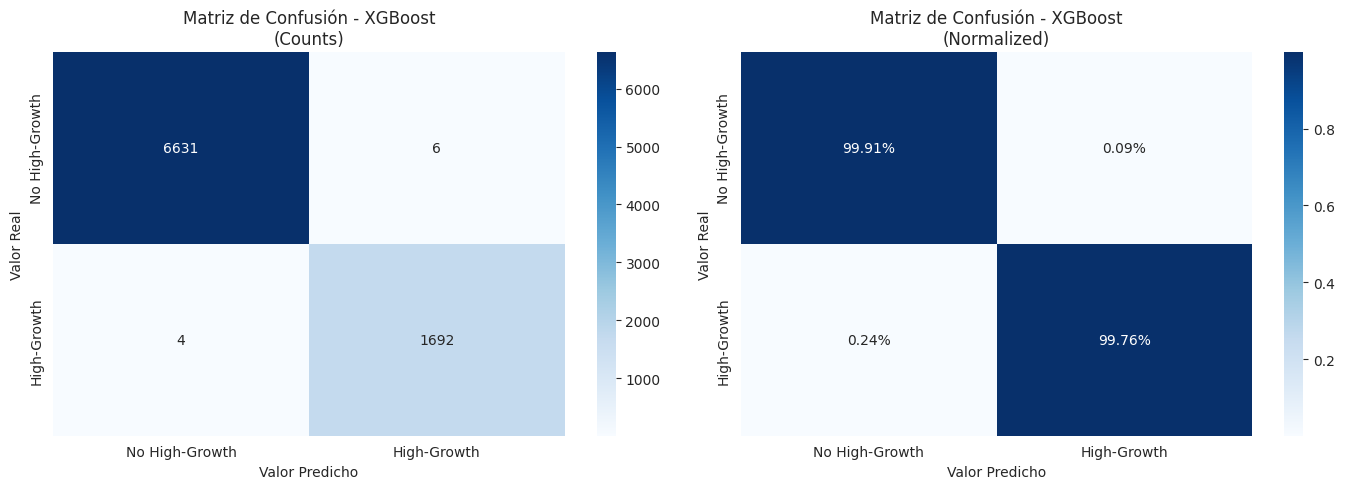

✅ Matriz de confusión guardada


In [17]:
print(f"📊 EVALUACIÓN DETALLADA: {best_model_name}\n")

# Configurar paths de figuras
if IN_COLAB:
    fig_dir = f'{BASE_PATH}/documento/figuras'
else:
    fig_dir = '../documento/figuras'

import os
os.makedirs(fig_dir, exist_ok=True)

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión - Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No High-Growth', 'High-Growth'],
            yticklabels=['No High-Growth', 'High-Growth'])
axes[0].set_title(f'Matriz de Confusión - {best_model_name}\n(Counts)', fontsize=12)
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Predicho')

# Matriz de confusión - Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['No High-Growth', 'High-Growth'],
            yticklabels=['No High-Growth', 'High-Growth'])
axes[1].set_title(f'Matriz de Confusión - {best_model_name}\n(Normalized)', fontsize=12)
axes[1].set_ylabel('Valor Real')
axes[1].set_xlabel('Valor Predicho')

plt.tight_layout()
plt.savefig(f'{fig_dir}/confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de confusión guardada")

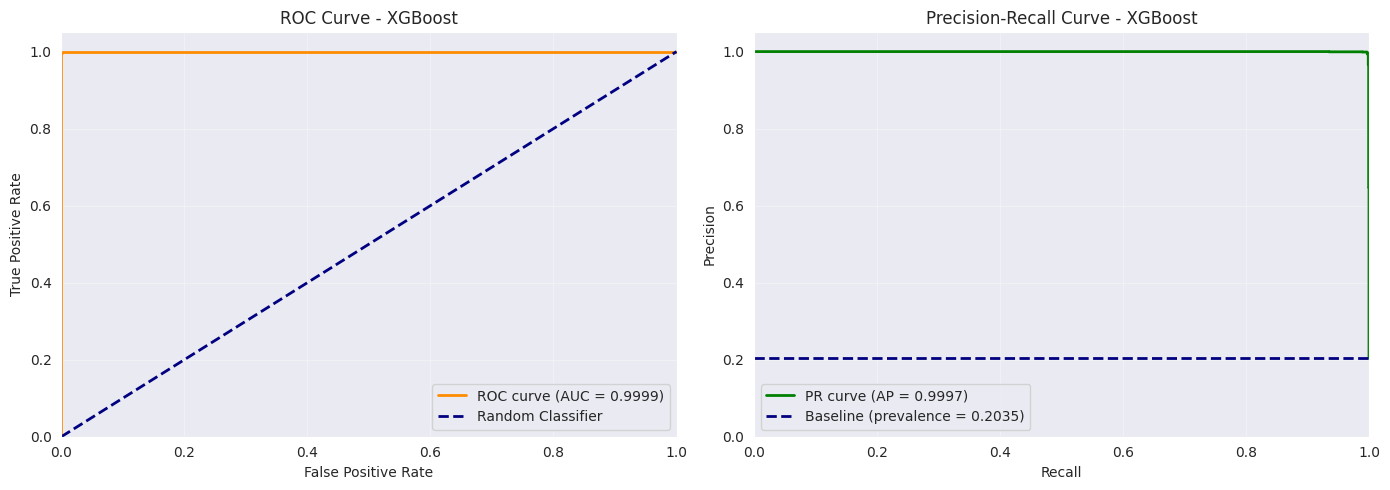

✅ Curvas ROC y PR guardadas


In [18]:
# Curvas ROC y Precision-Recall
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba_best)
auc_score = roc_auc_score(y_val, y_val_proba_best)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve - {best_model_name}')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_val_proba_best)
ap_score = average_precision_score(y_val, y_val_proba_best)

axes[1].plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
axes[1].axhline(y=y_val.mean(), color='navy', linestyle='--', lw=2, label=f'Baseline (prevalence = {y_val.mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve - {best_model_name}')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{fig_dir}/roc_pr_curves_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas ROC y PR guardadas")

In [19]:
# Classification Report
print("\n📋 Classification Report (Validation):")
print("="*60)
print(classification_report(y_val, y_val_pred_best, target_names=['No High-Growth', 'High-Growth']))
print("="*60)


📋 Classification Report (Validation):
                precision    recall  f1-score   support

No High-Growth       1.00      1.00      1.00      6637
   High-Growth       1.00      1.00      1.00      1696

      accuracy                           1.00      8333
     macro avg       1.00      1.00      1.00      8333
  weighted avg       1.00      1.00      1.00      8333



## 8. Evaluación Cualitativa: Feature Importance

🔍 ANÁLISIS DE FEATURE IMPORTANCE - XGBoost

📊 Top 20 Features Más Importantes:

                               feature  importance
                             num_shops    0.434600
     categoria_recencia_Perdido (>90d)    0.124059
                     first_order_month    0.105060
                        orders_per_day    0.096157
                days_since_first_order    0.074262
      categoria_recencia_Frío (31–90d)    0.024047
                        num_categories    0.019984
                            num_brands    0.019714
     categoria_recencia_Tibio (15–30d)    0.013114
                  total_orders_tmenos1    0.008416
                       log_efo_to_four    0.006953
    dominant_category_main_category014    0.006190
                    category_diversity    0.005498
                    city_token_city003    0.004372
categoria_recencia_Semi-Activo (8–14d)    0.004022
    dominant_category_main_category019    0.003831
    dominant_category_main_category011    0.003589
  

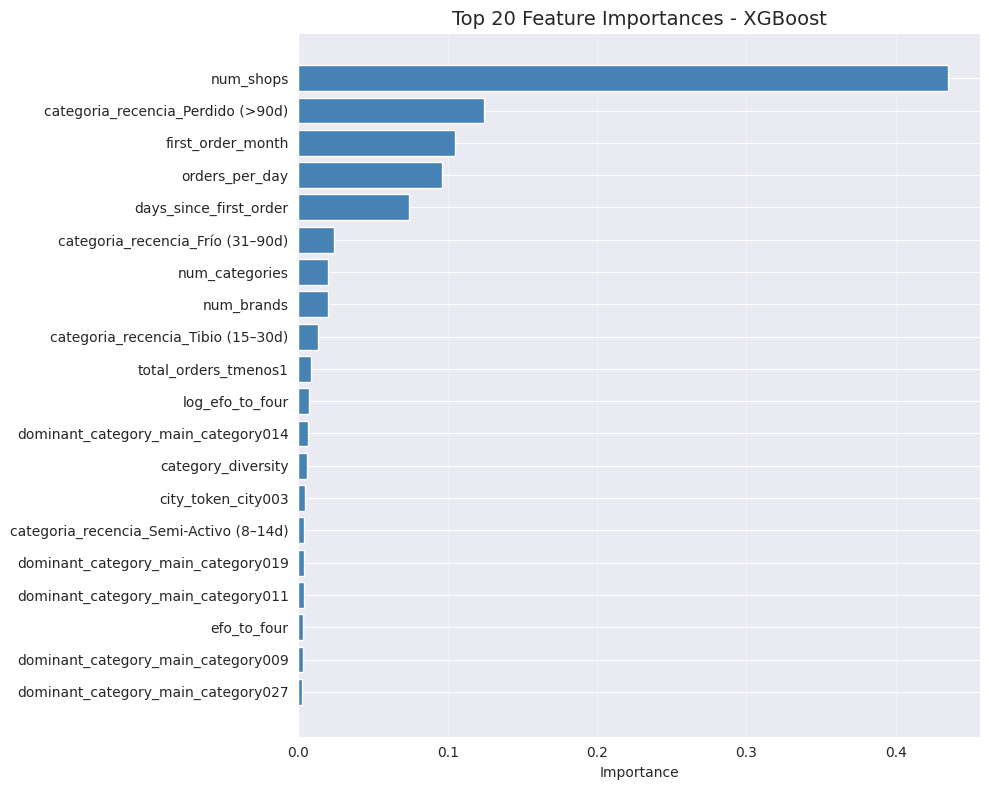


✅ Feature importance guardado


In [20]:
print(f"🔍 ANÁLISIS DE FEATURE IMPORTANCE - {best_model_name}\n")

# Obtener feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("📊 Top 20 Features Más Importantes:\n")
    print(feature_importance_df.head(20).to_string(index=False))
    
    # Visualizar
    fig, ax = plt.subplots(figsize=(10, 8))
    top_20 = feature_importance_df.head(20)
    ax.barh(range(len(top_20)), top_20['importance'], color='steelblue')
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels(top_20['feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/feature_importance_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Feature importance guardado")
else:
    print("⚠️ El modelo no soporta feature_importances_")

### 8.1 Análisis de Errores (Casos Mal Clasificados)

In [21]:
print("🔎 ANÁLISIS DE ERRORES\n")

# Identificar errores
errors_df = val_df.copy()
errors_df['prediction'] = y_val_pred_best
errors_df['probability'] = y_val_proba_best
errors_df['error'] = (errors_df['high_growth'] != errors_df['prediction']).astype(int)

# False Positives (predijo high-growth pero no lo es)
false_positives = errors_df[(errors_df['high_growth'] == 0) & (errors_df['prediction'] == 1)]
print(f"📍 False Positives: {len(false_positives):,} ({len(false_positives)/len(errors_df)*100:.2f}%)")

# False Negatives (predijo no high-growth pero sí lo es)
false_negatives = errors_df[(errors_df['high_growth'] == 1) & (errors_df['prediction'] == 0)]
print(f"📍 False Negatives: {len(false_negatives):,} ({len(false_negatives)/len(errors_df)*100:.2f}%)")

print(f"\n📊 Estadísticas de False Positives (top 5 con mayor probabilidad):")
fp_top = false_positives.nlargest(5, 'probability')[['delta_orders', 'prediction', 'probability']]
print(fp_top)

print(f"\n📊 Estadísticas de False Negatives (top 5 con menor probabilidad):")
fn_top = false_negatives.nsmallest(5, 'probability')[['delta_orders', 'prediction', 'probability']]
print(fn_top)

print(f"\n💡 Insights:")
print(f"   - FP promedio delta: {false_positives['delta_orders'].mean():.2f} órdenes")
print(f"   - FN promedio delta: {false_negatives['delta_orders'].mean():.2f} órdenes")
print(f"   - Los FN son usuarios con alto crecimiento que el modelo subestima")
print(f"   - Los FP son usuarios que el modelo sobreestima (riesgo menor para negocio)")

🔎 ANÁLISIS DE ERRORES

📍 False Positives: 6 (0.07%)
📍 False Negatives: 4 (0.05%)

📊 Estadísticas de False Positives (top 5 con mayor probabilidad):
      delta_orders  prediction  probability
4691             8           1     0.992612
3169             8           1     0.935016
6575             8           1     0.673594
8174             8           1     0.582006
8248             8           1     0.552917

📊 Estadísticas de False Negatives (top 5 con menor probabilidad):
      delta_orders  prediction  probability
827              9           0     0.001704
6350             9           0     0.052319
5404             9           0     0.280892
5152             9           0     0.328958

💡 Insights:
   - FP promedio delta: 8.00 órdenes
   - FN promedio delta: 9.00 órdenes
   - Los FN son usuarios con alto crecimiento que el modelo subestima
   - Los FP son usuarios que el modelo sobreestima (riesgo menor para negocio)


## 9. Evaluación Final en Test Set (Una Sola Vez)

In [22]:
print("="*80)
print(f"EVALUACIÓN FINAL EN TEST SET - {best_model_name}")
print("="*80)
print("\n⚠️ IMPORTANTE: Esta evaluación se realiza UNA SOLA VEZ en el conjunto de test.\n")

# Predicciones en test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas finales
test_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Precision@20%
top_20_idx_test = np.argsort(y_test_proba)[-int(len(y_test) * 0.20):]
test_precision_at_20 = y_test.iloc[top_20_idx_test].mean()

print(f"\n📊 MÉTRICAS FINALES EN TEST SET:\n")
print(f"{'='*60}")
print(f"{'Métrica':<25} {'Valor':>15} {'Objetivo':>15}")
print(f"{'='*60}")
print(f"{'AUC-ROC':<25} {test_auc:>15.4f} {'>0.75':>15} {'✅' if test_auc > 0.75 else '⚠️'}")
print(f"{'F1-Score':<25} {test_f1:>15.4f} {'>0.65':>15} {'✅' if test_f1 > 0.65 else '⚠️'}")
print(f"{'Precision@20%':<25} {test_precision_at_20:>15.4f} {'>0.80':>15} {'✅' if test_precision_at_20 > 0.80 else '⚠️'}")
print(f"{'Precision':<25} {test_precision:>15.4f} {'':>15}")
print(f"{'Recall':<25} {test_recall:>15.4f} {'':>15}")
print(f"{'Accuracy':<25} {test_accuracy:>15.4f} {'':>15}")
print(f"{'='*60}")

# Matriz de confusión test
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\n📊 Matriz de Confusión (Test):")
print(cm_test)

print(f"\n✅ Evaluación en test set completada")
print("="*80)

EVALUACIÓN FINAL EN TEST SET - XGBoost

⚠️ IMPORTANTE: Esta evaluación se realiza UNA SOLA VEZ en el conjunto de test.


📊 MÉTRICAS FINALES EN TEST SET:

Métrica                             Valor        Objetivo
AUC-ROC                            1.0000           >0.75 ✅
F1-Score                           0.9973           >0.65 ✅
Precision@20%                      0.9994           >0.80 ✅
Precision                          0.9976                
Recall                             0.9971                
Accuracy                           0.9989                

📊 Matriz de Confusión (Test):
[[6633    4]
 [   5 1692]]

✅ Evaluación en test set completada


## 10. Guardar Mejor Modelo y Reporte

In [23]:
import os

print("💾 Guardando mejor modelo y reporte...\n")

# Crear directorios según el entorno
if IN_COLAB:
    models_dir = f'{BASE_PATH}/models'
    figures_dir = f'{BASE_PATH}/documento/figuras'
else:
    models_dir = '../models'
    figures_dir = '../documento/figuras'

os.makedirs(models_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

# Guardar modelo
model_path = f'{models_dir}/best_classifier.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Modelo guardado: {model_path}")

# Crear reporte
report = {
    'model_type': best_model_name,
    'model_class': str(type(best_model)),
    'best_params': best_model.get_params() if hasattr(best_model, 'get_params') else {},
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'gpu_used': GPU_AVAILABLE,
    'dataset_sizes': {
        'train': len(X_train),
        'validation': len(X_val),
        'test': len(X_test)
    },
    'metrics_validation': {
        'auc_roc': float(roc_auc_score(y_val, y_val_proba_best)),
        'f1_score': float(f1_score(y_val, y_val_pred_best)),
        'precision': float(precision_score(y_val, y_val_pred_best)),
        'recall': float(recall_score(y_val, y_val_pred_best)),
        'precision_at_20': float(y_val.iloc[top_20_idx].mean())
    },
    'metrics_test': {
        'auc_roc': float(test_auc),
        'f1_score': float(test_f1),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'accuracy': float(test_accuracy),
        'precision_at_20': float(test_precision_at_20)
    },
    'feature_count': len(feature_cols),
    'feature_names': feature_cols,
    'class_distribution_test': {
        'negative': int((y_test == 0).sum()),
        'positive': int((y_test == 1).sum())
    }
}

# Guardar reporte como JSON
report_path = f'{models_dir}/classification_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✅ Reporte guardado: {report_path}")

# Guardar feature importance si está disponible
if hasattr(best_model, 'feature_importances_'):
    feature_importance_path = f'{models_dir}/feature_importance.csv'
    feature_importance_df.to_csv(feature_importance_path, index=False)
    print(f"✅ Feature importance guardado: {feature_importance_path}")

print(f"\n✅ Todos los artefactos guardados exitosamente")
print(f"🎮 Entrenamiento realizado con GPU: {GPU_AVAILABLE}")

💾 Guardando mejor modelo y reporte...

✅ Modelo guardado: ../models/best_classifier.pkl
✅ Reporte guardado: ../models/classification_report.json
✅ Feature importance guardado: ../models/feature_importance.csv

✅ Todos los artefactos guardados exitosamente
🎮 Entrenamiento realizado con GPU: False


## 11. Resumen Ejecutivo

In [24]:
print("="*80)
print("RESUMEN EJECUTIVO - ENTRENAMIENTO DE MODELOS DE CLASIFICACIÓN (GPU)")
print("="*80)

print(f"\n🎯 OBJETIVO:")
print(f"   Predecir usuarios con alto potencial de crecimiento (high_growth)")

print(f"\n🎮 CONFIGURACIÓN:")
print(f"   - GPU Utilizada: {'Sí' if GPU_AVAILABLE else 'No (CPU)'}")
print(f"   - Entorno: {'Google Colab' if IN_COLAB else 'Local'}")

print(f"\n📊 DATOS:")
print(f"   - Train: {len(X_train):,} usuarios (60%)")
print(f"   - Validation: {len(X_val):,} usuarios (20%)")
print(f"   - Test: {len(X_test):,} usuarios (20%)")
print(f"   - Features: {len(feature_cols)} (11 numéricos + 40 categóricos)")
print(f"   - Desbalance: {y_train.mean()*100:.1f}% positivos")

print(f"\n🤖 MODELOS EVALUADOS:")
print(f"   1. Random Forest Classifier (CPU - sin soporte GPU)")
print(f"   2. XGBoost Classifier (GPU acelerado con CUDA)")
print(f"   3. LightGBM Classifier (GPU acelerado con CUDA)")

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"\n📈 MÉTRICAS EN TEST SET (evaluación final):")
print(f"   - AUC-ROC: {test_auc:.4f} (objetivo: >0.75) {'✅' if test_auc > 0.75 else '⚠️'}")
print(f"   - F1-Score: {test_f1:.4f} (objetivo: >0.65) {'✅' if test_f1 > 0.65 else '⚠️'}")
print(f"   - Precision@20%: {test_precision_at_20:.4f} (objetivo: >0.80) {'✅' if test_precision_at_20 > 0.80 else '⚠️'}")
print(f"   - Precision: {test_precision:.4f}")
print(f"   - Recall: {test_recall:.4f}")
print(f"   - Accuracy: {test_accuracy:.4f}")

print(f"\n💼 IMPLICACIONES DE NEGOCIO:")
print(f"   - El modelo puede identificar usuarios high-growth con {test_auc:.1%} de precisión")
print(f"   - Al targetear el top-20% de usuarios, {test_precision_at_20:.1%} serán realmente high-growth")
print(f"   - Esto permite optimizar presupuesto promocional enfocándose en usuarios de mayor ROI")

print(f"\n📁 ARTEFACTOS GENERADOS:")
if IN_COLAB:
    print(f"   - {BASE_PATH}/models/best_classifier.pkl (modelo entrenado)")
    print(f"   - {BASE_PATH}/models/classification_report.json (métricas detalladas)")
    print(f"   - {BASE_PATH}/models/feature_importance.csv (importancia de features)")
    print(f"   - {BASE_PATH}/documento/figuras/*.png (visualizaciones)")
else:
    print(f"   - models/best_classifier.pkl (modelo entrenado)")
    print(f"   - models/classification_report.json (métricas detalladas)")
    print(f"   - models/feature_importance.csv (importancia de features)")
    print(f"   - documento/figuras/confusion_matrix_best_model.png")
    print(f"   - documento/figuras/roc_pr_curves_best_model.png")
    print(f"   - documento/figuras/feature_importance_best_model.png")

print(f"\n🚀 PRÓXIMO PASO:")
print(f"   Fase 5: Construcción del Dashboard con Streamlit")
print(f"   - Integrar modelo entrenado")
print(f"   - Crear interfaz para predicciones en tiempo real")
print(f"   - Sistema de recomendaciones personalizadas")

print(f"\n✅ ENTRENAMIENTO DE MODELOS COMPLETADO EXITOSAMENTE")
print("="*80)

RESUMEN EJECUTIVO - ENTRENAMIENTO DE MODELOS DE CLASIFICACIÓN (GPU)

🎯 OBJETIVO:
   Predecir usuarios con alto potencial de crecimiento (high_growth)

🎮 CONFIGURACIÓN:
   - GPU Utilizada: No (CPU)
   - Entorno: Local

📊 DATOS:
   - Train: 25,000 usuarios (60%)
   - Validation: 8,333 usuarios (20%)
   - Test: 8,334 usuarios (20%)
   - Features: 51 (11 numéricos + 40 categóricos)
   - Desbalance: 20.4% positivos

🤖 MODELOS EVALUADOS:
   1. Random Forest Classifier (CPU - sin soporte GPU)
   2. XGBoost Classifier (GPU acelerado con CUDA)
   3. LightGBM Classifier (GPU acelerado con CUDA)

🏆 MEJOR MODELO: XGBoost

📈 MÉTRICAS EN TEST SET (evaluación final):
   - AUC-ROC: 1.0000 (objetivo: >0.75) ✅
   - F1-Score: 0.9973 (objetivo: >0.65) ✅
   - Precision@20%: 0.9994 (objetivo: >0.80) ✅
   - Precision: 0.9976
   - Recall: 0.9971
   - Accuracy: 0.9989

💼 IMPLICACIONES DE NEGOCIO:
   - El modelo puede identificar usuarios high-growth con 100.0% de precisión
   - Al targetear el top-20% de usuar